# Final Project -Feature Engineering

## Feature Engineering

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
labels=['viral_pneumonia', 'covid-19', 'bacterial_pneumonia', 'normal']

def load_data():
    X, y = [], []
    
    for label in labels:
        path=os.path.join('raw_data', label)
        files=os.listdir(path)
        print(label)
        
        for file_name in files:
            file_path = os.path.join(path, file_name)
            image = Image.open(file_path)
            image = image.resize((256, 256))
            image = image.convert('1')
            
            X.append(np.array(image))
            y.append(label)
            
    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
    return np.array(X), np.array(y)

In [3]:
X, y = load_data();

viral_pneumonia
covid-19
bacterial_pneumonia
normal


In [4]:
dim=[image.ndim for image in X]
count=0
   
for i in dim:
    if i ==3:
        count+=1
print(count)
print(len(dim))
count/len(dim)*100

0
6662


0.0

In [5]:
size=[image.size for image in X]
count=0
index=0
index_list=[]

for i in size:
    if i== 65536:
        count+=1
        index+=1
        
    else:
        index+=1
        index_list.append(i)
        

print(count)
print(len(index_list))


6662
0


Text(0.5, 1.0, 'viral_pneumonia')

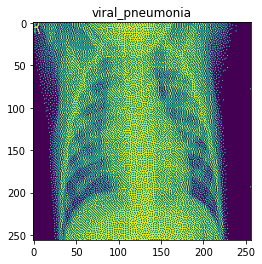

In [6]:
plt.imshow(X[300])
plt.title(y[300])

Text(0.5, 1.0, 'bacterial_pneumonia')

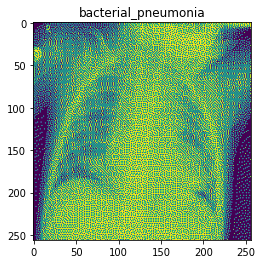

In [7]:
plt.imshow(X[-1])
plt.title(y[-1])

In [8]:
X.shape

(6662, 256, 256)

## Normalisation & Encode

### Normalise

In [9]:
X_norm= X/255

In [10]:
X_norm[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00392157,
        0.        ],
       [0.        , 0.00392157, 0.        , ..., 0.00392157, 0.        ,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00392157,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.00392157,
        0.00392157],
       [0.00392157, 0.        , 0.00392157, ..., 0.00392157, 0.00392157,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]])

### OneHotEncode

In [12]:
y.shape

(6662,)

In [13]:
y[69]

'bacterial_pneumonia'

In [14]:
type(y)
np.unique(y)

array(['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia'],
      dtype='<U19')

In [15]:
len(np.unique(y))

4

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [17]:
le.classes_

array(['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia'],
      dtype='<U19')

In [18]:
y_enc=le.transform(y)

In [19]:
np.unique(y_enc)

array([0, 1, 2, 3])

In [20]:
y_enc= y_enc

In [21]:
from tensorflow import one_hot

y_cat = one_hot(y_enc, 4)

# y_cat=enc.transform(y_enc)

In [22]:
y_cat[:3,]

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [23]:
y_cat=np.array(y_cat)

## Split

In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [28]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_cat, test_size=0.2)

In [ ]:
#SPLIT
# X = np.array(imgs)
#     num_classes = len(set(labels))
#     y = to_categorical(labels, num_classes)

#     # Finally we shuffle:
#     p = np.random.permutation(len(X))
#     X, y = X[p], y[p]

#     first_split = int(len(imgs) /6.)
#     second_split = first_split + int(len(imgs) * 0.2)
#     X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
#     y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
#     return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

## Expand Dimensions

In [29]:
from tensorflow.keras.backend import expand_dims

X_train_ex= expand_dims(X_train, axis=-1)
X_test_ex= expand_dims(X_test, axis=-1)

print(X_train_ex.shape)
print(X_test_ex.shape)

(5329, 256, 256, 1)
(1333, 256, 256, 1)


In [34]:
y_train.shape

(5329, 4)

## Model

In [35]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import tensorflow as tf

num_classes = 4
def initialize_model():
    model = tf.keras.Sequential([
      layers.Conv2D(32, 3, activation='relu', input_shape=(256, 256, 1)),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(4, activation='softmax')
    ])
    return model


In [40]:
model = initialize_model()

#tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [41]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train_ex, y_train,
          batch_size=32,
          epochs=100,
          validation_split=0.2,
          callbacks=[es])

Epoch 1/100
134/134 [==============================] - 326s 2s/step - loss: 1.3422 - accuracy: 0.3785 - val_loss: 1.3128 - val_accuracy: 0.4099
Epoch 2/100
134/134 [==============================] - 252s 2s/step - loss: 1.3269 - accuracy: 0.4009 - val_loss: 1.3205 - val_accuracy: 0.4099
Epoch 3/100
134/134 [==============================] - 234s 2s/step - loss: 1.3277 - accuracy: 0.3954 - val_loss: 1.3138 - val_accuracy: 0.4099
Epoch 4/100
134/134 [==============================] - 283s 2s/step - loss: 1.3214 - accuracy: 0.4073 - val_loss: 1.3132 - val_accuracy: 0.4099
Epoch 5/100
134/134 [==============================] - 320s 2s/step - loss: 1.3323 - accuracy: 0.3979 - val_loss: 1.3147 - val_accuracy: 0.4099
Epoch 6/100
134/134 [==============================] - 340s 3s/step - loss: 1.3298 - accuracy: 0.3949 - val_loss: 1.3143 - val_accuracy: 0.4099


In [107]:
X_train.shape
# def initialize_model():
#     model = models.Sequential()
    
#     model.add(layers.Dense(25, activation='relu', input_dim=1)) 
#     model.add(layers.Dense(10, activation='relu')) 
#     model.add(layers.Dense(10, activation='relu')) 
    
#     model.add(layers.Dense(4, activation='softmax')) 
    
#     ### Model optimization : Optimizer, loss and metric 
#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

(5329, 256, 256)

In [ ]:
def initialize_model():
    model = Sequential()

    ### First convolution & max-pooling
    model.add(layers.Conv2D(32, (3,3),activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Second convolution & max-pooling
    model.add(layers.Conv2D(64, (3,3),activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Third convolution & max-pooling
    model.add(layers.Conv2D(128, (3,3),activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    ### Flattening
    model.add(layers.Flatten())

    ### One fully connected
    model.add(layers.Dense(120, activation='relu'))

    model.add(layers.Dense(60, activation='relu'))

    model.add(layers.Dropout(rate=0.5))

    ### Last layer (let's say a classification with 10 output)
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

In [ ]:
model = initialize_model()

history = model.fit(X_train, y_train, 
                    epochs=50,
                    batch_size=8,
                    verbose=0)